In [1]:
from pymongo import MongoClient
from pprint import pprint
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import itertools
import time
import re

In [2]:
%%time

floor_range = range(0, 55)

match = {
    'event.character_chosen': 'IRONCLAD', 
    'event.floor_reached': {
        '$gte': 40
    }, 
    'event.ascension_level': {
        '$gte': 15
    },
    "event.relics": {
        '$nin': ['PrismaticShard']
    },
    "event.is_beta": False,
    "event.is_endless": False,
}

client = MongoClient('mongodb://localhost:27017')
db = client.spire
status = db.command('serverStatus')
runs = db.runs

not_picks_agg = [
    {
        '$match': match
    }, {
        '$project': {
            'event.card_choices': 1, 
            'event.ascension_level': 1
        }
    }, {
        '$unwind': {
            'path': '$event.card_choices'
        }
    }, {
        '$unwind': {
            'path': '$event.card_choices.not_picked'
        }
    }, {
        '$project': {
            'event.card_choices.not_picked': 1, 
            'event.card_choices.floor': 1, 
            'event.ascension_level': 1
        }
    }, {
        '$group': {
            '_id': {
                'not_picked': '$event.card_choices.not_picked', 
                'floor': '$event.card_choices.floor'
            }, 
            'count': {
                '$sum': 1
            }, 
            'card': {
                '$first': '$event.card_choices.not_picked'
            }, 
            'floor': {
                '$first': '$event.card_choices.floor'
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }
]
not_picks_result = runs.aggregate(not_picks_agg)
tmp = pd.DataFrame(list(not_picks_result))
tmp

CPU times: user 108 ms, sys: 10.8 ms, total: 119 ms
Wall time: 1.9 s


,_id,count,card,floor
0,"{'not_picked': 'Brutality', 'floor': 16}",1475,Brutality,16.0
1,"{'not_picked': 'Exhume', 'floor': 16.0}",1448,Exhume,16.0
2,"{'not_picked': 'Berserk', 'floor': 16}",1415,Berserk,16.0
3,"{'not_picked': 'Bludgeon', 'floor': 16}",1388,Bludgeon,16.0
4,"{'not_picked': 'Juggernaut', 'floor': 16}",1375,Juggernaut,16.0
...,...,...,...,...
7215,"{'not_picked': 'Offering', 'floor': 2.0}",1,Offering,2.0
7216,"{'not_picked': 'Secret Technique+1', 'floor': ...",1,Secret Technique+1,37.0
7217,"{'not_picked': 'Blood for Blood', 'floor': 98}",1,Blood for Blood,98.0
7218,"{'not_picked': 'Barricade+1', 'floor': 37.0}",1,Barricade+1,37.0


In [3]:
commons = [
    'Wild Strike',
    'Perfected Strike',
    'Anger',
    'Iron Wave',
    'Heavy Blade',
    'Clothesline',
    'Flex',
    'Havoc',
    'Pommel Strike',
    'Warcry',
    'Twin Strike',
    'True Grit',
    'Thunderclap',
    'Sword Boomerang',
    'Body Slam',
    'Clash',
    'Armaments',
    'Cleave',
    'Shrug It Off',
    'Headbutt',
]
uncommons = [
    'Shockwave',
    'Intimidate',
    'Bloodletting',
    'Burning Pact',
    'Spot Weakness',
    'Metallicize',
    'Rampage',
    'Inflame',
    'Seeing Red',
    'Second Wind',
    'Searing Blow',
    'Rupture',
    'Reckless Charge',
    'Sever Soul',
    'Rage',
    'Disarm',
    'Pummel',
    'Power Through',
    # missing items
    'Entrench',
    # missing items
]
rares = [
    'Demon Form',
    'Juggernaut',
    'Offering',
    'Feed',
    'Corruption',
    'Berserk',
    'Reaper',
    'Bludgeon',
    'Limit Break',
    'Double Tap',
    'Exhume',
    'Immolate',
    'Fiend Fire',
    'Barricade',
    'Brutality',
    'Impervious',
]

commons_plus = [card+"+1" for card in commons]
uncommons_plus = [card+"+1" for card in uncommons]

In [4]:
not_picks_df = tmp.pivot(index='card', columns='floor')['count']
not_picks_df = not_picks_df[floor_range]
not_picks_df.loc['Bludgeon'][:30]

floor
0.0       37.0
1.0        NaN
2.0        3.0
3.0        4.0
4.0        9.0
5.0       15.0
6.0       43.0
7.0       48.0
8.0       33.0
9.0        NaN
10.0      41.0
11.0      28.0
12.0      45.0
13.0      37.0
14.0      48.0
15.0       1.0
16.0    1388.0
17.0       NaN
18.0       2.0
19.0       5.0
20.0       8.0
21.0      11.0
22.0      23.0
23.0      50.0
24.0      46.0
25.0      37.0
26.0       NaN
27.0      46.0
28.0      44.0
29.0      45.0
30.0      56.0
Name: Bludgeon, dtype: float64

In [5]:
not_picks_df

floor,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0
card,,,,,,,,,,,,,,,,,,,,,
Anger,9.0,694.0,271.0,284.0,332.0,347.0,272.0,378.0,358.0,NaN,...,203.0,234.0,178.0,289.0,17.0,1.0,NaN,1.0,5.0,41.0
Anger+1,NaN,NaN,NaN,1.0,2.0,2.0,2.0,5.0,9.0,NaN,...,122.0,118.0,130.0,190.0,11.0,NaN,NaN,NaN,8.0,18.0
Apotheosis,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,4.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
Apotheosis+1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Armaments,8.0,633.0,218.0,240.0,272.0,282.0,255.0,326.0,273.0,NaN,...,215.0,220.0,229.0,280.0,11.0,NaN,NaN,1.0,5.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Warcry+1,NaN,NaN,NaN,2.0,1.0,1.0,8.0,3.0,15.0,NaN,...,93.0,99.0,96.0,152.0,4.0,NaN,NaN,1.0,1.0,15.0
Whirlwind,1.0,97.0,48.0,54.0,60.0,72.0,73.0,97.0,88.0,NaN,...,62.0,64.0,75.0,92.0,1.0,NaN,NaN,NaN,3.0,6.0
Whirlwind+1,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,...,51.0,29.0,25.0,57.0,1.0,NaN,2.0,1.0,4.0,12.0


In [6]:
%%time
picks_agg = [
    {
        '$match': match
    }, {
        '$project': {
            'event.card_choices': 1, 
            'event.ascension_level': 1
        }
    }, {
        '$unwind': {
            'path': '$event.card_choices'
        }
    # }, {
    #     '$match': {
    #         'event.card_choices.picked': {
    #             '$ne': 'SKIP'
    #         }
    #     }
    }, {
        '$group': {
            '_id': {
                'picked': '$event.card_choices.picked', 
                'floor': '$event.card_choices.floor'
            }, 
            'count': {
                '$sum': 1
            }, 
            'card': {
                '$first': '$event.card_choices.picked'
            }, 
            'floor': {
                '$first': '$event.card_choices.floor'
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }
]
picks_result = runs.aggregate(picks_agg)
tmp = pd.DataFrame(list(picks_result))
tmp

CPU times: user 47.6 ms, sys: 878 µs, total: 48.5 ms
Wall time: 665 ms


,_id,count,card,floor
0,"{'picked': 'SKIP', 'floor': 35}",5110,SKIP,35.0
1,"{'picked': 'SKIP', 'floor': 18.0}",3927,SKIP,18.0
2,"{'picked': 'SKIP', 'floor': 31}",3011,SKIP,31.0
3,"{'picked': 'SKIP', 'floor': 48}",2629,SKIP,48.0
4,"{'picked': 'SKIP', 'floor': 39}",2542,SKIP,39.0
...,...,...,...,...
6696,"{'picked': 'Transmutation', 'floor': 40}",1,Transmutation,40.0
6697,"{'picked': 'Havoc', 'floor': 0.0}",1,Havoc,0.0
6698,"{'picked': 'Madness+1', 'floor': 39}",1,Madness+1,39.0
6699,"{'picked': 'Barricade+1', 'floor': 30.0}",1,Barricade+1,30.0


In [7]:
picks_df = tmp.pivot(index='card', columns='floor')['count']
# remove floors 55 and above because the game ends at 55. Don't know how we have records above 55
picks_df = picks_df[floor_range]
picks_df.loc['Bludgeon'][16]

183.0

In [8]:
not_picks_df.loc['Bludgeon+1'][16]

88.0

In [9]:
not_picks_df.loc['Bludgeon'][16]

1388.0

In [10]:
offered_df = picks_df + not_picks_df

In [11]:
offered_df.loc['Bludgeon'][16]

1571.0

In [12]:
pickrate_df = picks_df / offered_df
print('offered')
print(offered_df.loc[['Bludgeon', 'Limit Break', 'Offering']].iloc[: , 16:30])
print('pickrate')
print(pickrate_df.loc[['Bludgeon', 'Limit Break', 'Offering']].iloc[: , 16:30])


offered
floor          16.0  17.0  18.0  19.0  20.0  21.0  22.0  23.0  24.0  25.0  \
card                                                                        
Bludgeon     1571.0   NaN   NaN   6.0  10.0  16.0  25.0  63.0  57.0  46.0   
Limit Break  1747.0   NaN   NaN  10.0  16.0  18.0  18.0  63.0  58.0  65.0   
Offering     1882.0   NaN   NaN  10.0  16.0  14.0  30.0  77.0  79.0  57.0   

floor        26.0  27.0  28.0  29.0  
card                                 
Bludgeon      NaN  59.0  52.0  55.0  
Limit Break   NaN  67.0  50.0  57.0  
Offering      NaN  63.0  41.0  68.0  
pickrate
floor            16.0  17.0  18.0      19.0  20.0      21.0      22.0  \
card                                                                    
Bludgeon     0.116486   NaN   NaN  0.166667  0.20  0.312500  0.080000   
Limit Break  0.490555   NaN   NaN  0.600000  0.50  0.666667  0.555556   
Offering     0.540383   NaN   NaN  0.800000  0.75  0.785714  0.833333   

floor            23.0      24.0      25.0

AxesSubplot(0.125,0.125;0.775x0.755)


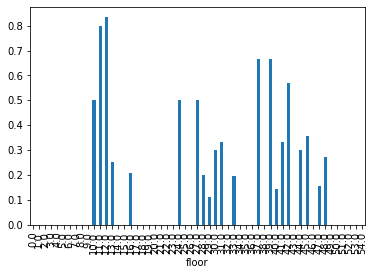

In [13]:
import matplotlib.pyplot as plt
print(pickrate_df.loc['Bludgeon+1'].T.plot(kind="bar"))

In [14]:
pickrate_df

floor,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0
card,,,,,,,,,,,,,,,,,,,,,
Anger,0.307692,0.248918,0.232295,0.232432,0.176179,0.191142,0.190476,0.174672,0.163551,NaN,...,0.004902,0.012658,0.016575,0.017007,NaN,NaN,NaN,NaN,NaN,NaN
Anger+1,NaN,NaN,NaN,NaN,0.333333,NaN,0.500000,0.583333,0.250000,NaN,...,0.075758,0.040650,0.044118,0.040404,0.214286,NaN,NaN,NaN,NaN,0.052632
Apotheosis,0.911765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.888889,0.636364,0.750000,0.666667,NaN,NaN,NaN,NaN,NaN,NaN
Apotheosis+1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Armaments,0.333333,0.352098,0.369942,0.337017,0.342995,0.308824,0.260870,0.225653,0.308861,NaN,...,0.022727,0.035088,0.037815,0.034483,NaN,NaN,NaN,NaN,0.166667,0.027027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Warcry+1,NaN,NaN,NaN,0.333333,0.666667,0.666667,0.200000,0.666667,0.117647,NaN,...,0.261905,0.238462,0.225806,0.208333,0.555556,NaN,NaN,NaN,0.500000,0.400000
Whirlwind,0.888889,0.729805,0.661972,0.611511,0.631902,0.581395,0.585227,0.535885,0.463415,NaN,...,0.138889,0.146667,0.085366,0.080000,0.500000,NaN,NaN,NaN,NaN,NaN
Whirlwind+1,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.600000,NaN,NaN,...,0.203125,0.171429,0.264706,0.185714,0.500000,NaN,NaN,NaN,NaN,0.076923


[<AxesSubplot:title={'center':'Wild Strike'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Perfected Strike'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Anger'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Iron Wave'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Heavy Blade'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Clothesline'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Flex'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Havoc'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Pommel Strike'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Warcry'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Twin Strike'}, xlabel='floor'>
 <AxesSubplot:title={'center':'True Grit'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Thunderclap'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Sword Boomerang'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Body Slam'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Clash'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Ar

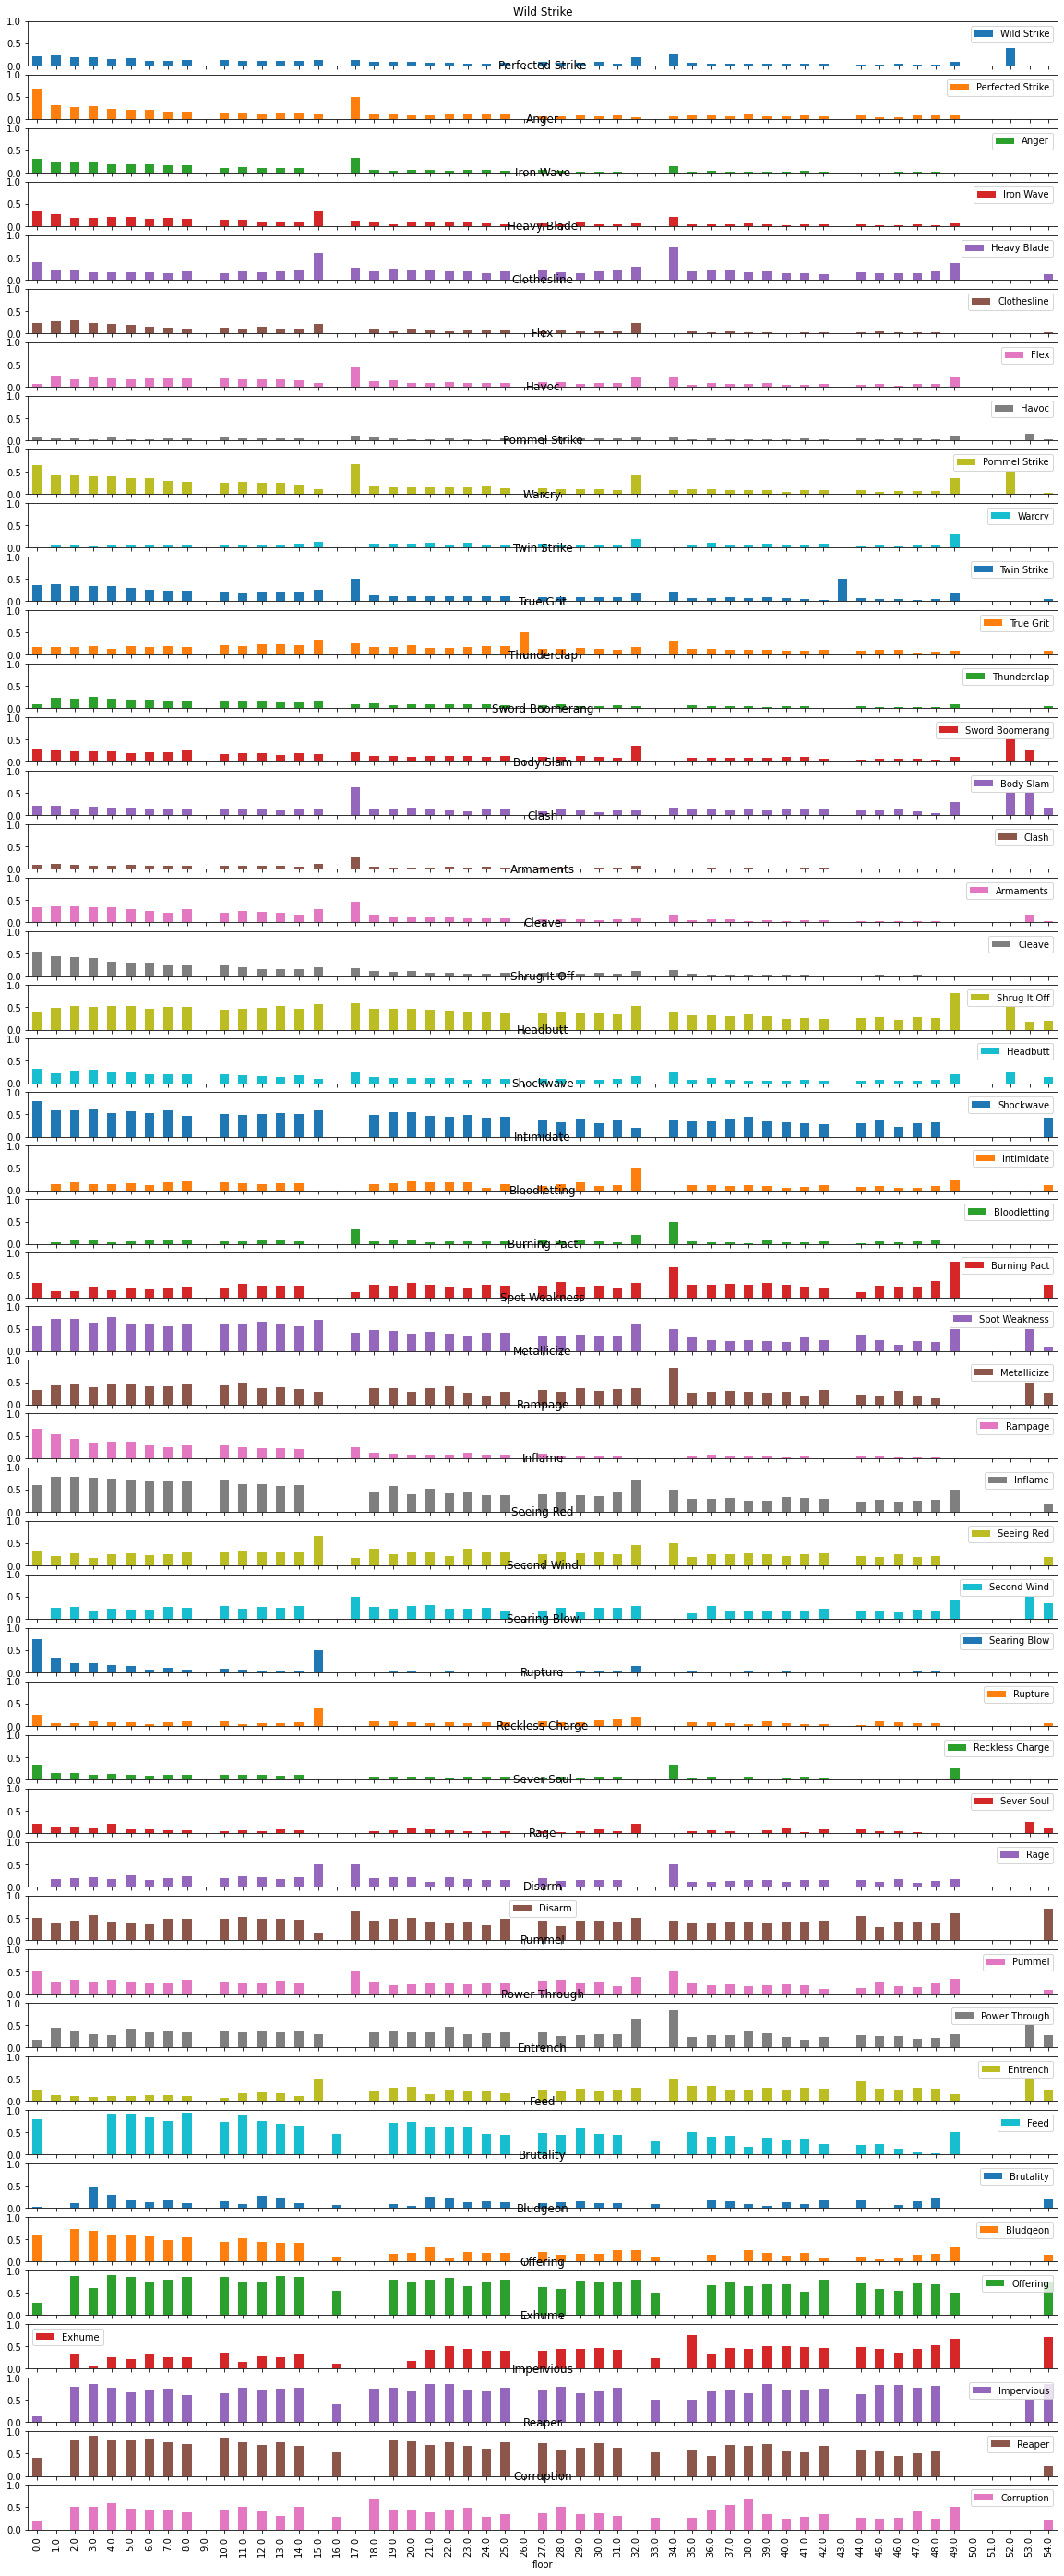

In [15]:
%%time
print(pickrate_df.loc[[
    'Wild Strike',
    'Perfected Strike',
    'Anger',
    'Iron Wave',
    'Heavy Blade',
    'Clothesline',
    'Flex',
    'Havoc',
    'Pommel Strike',
    'Warcry',
    'Twin Strike',
    'True Grit',
    'Thunderclap',
    'Sword Boomerang',
    'Body Slam',
    'Clash',
    'Armaments',
    'Cleave',
    'Shrug It Off',
    'Headbutt',
    'Shockwave',
    'Intimidate',
    'Bloodletting',
    'Burning Pact',
    'Spot Weakness',
    'Metallicize',
    'Rampage',
    'Inflame',
    'Seeing Red',
    'Second Wind',
    'Searing Blow',
    'Rupture',
    'Reckless Charge',
    'Sever Soul',
    'Rage',
    'Disarm',
    'Pummel',
    'Power Through',
    
    'Entrench',
    
    'Feed',
    'Brutality',
    'Bludgeon',
    'Offering',
    'Exhume',
    'Impervious',
    'Reaper',
    'Corruption',
]].T.plot(kind="bar", figsize=(20, 50), subplots=True, ylim=(0,1)))

array([<AxesSubplot:title={'center':'Wild Strike+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Perfected Strike+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Anger+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Iron Wave+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Heavy Blade+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Clothesline+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Flex+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Havoc+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Pommel Strike+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Warcry+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Twin Strike+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'True Grit+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Thunderclap+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Sword Boomerang+1'}, xlabel='floor'>,
       <AxesSubplot:tit

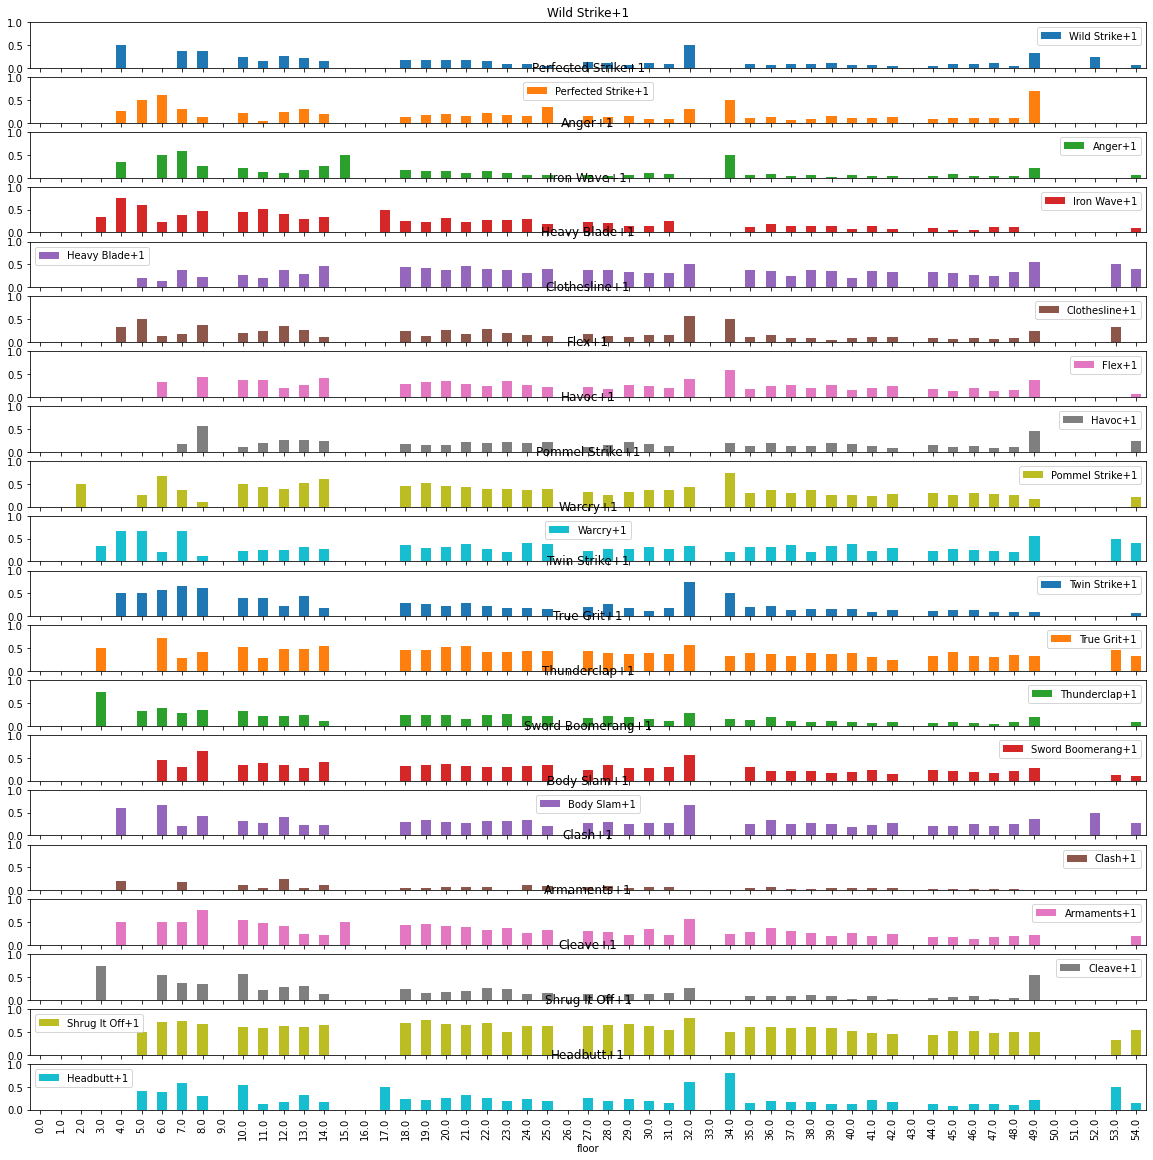

In [16]:
pickrate_df.loc[commons_plus].T.plot(kind="bar", figsize=(20, 20), subplots=True, ylim=(0,1))

array([<AxesSubplot:title={'center':'Shockwave+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Intimidate+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Bloodletting+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Burning Pact+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Spot Weakness+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Metallicize+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Rampage+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Inflame+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Seeing Red+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Second Wind+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Searing Blow+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Rupture+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Reckless Charge+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Sever Soul+1'}, xlabel='floor'>,
       <AxesSu

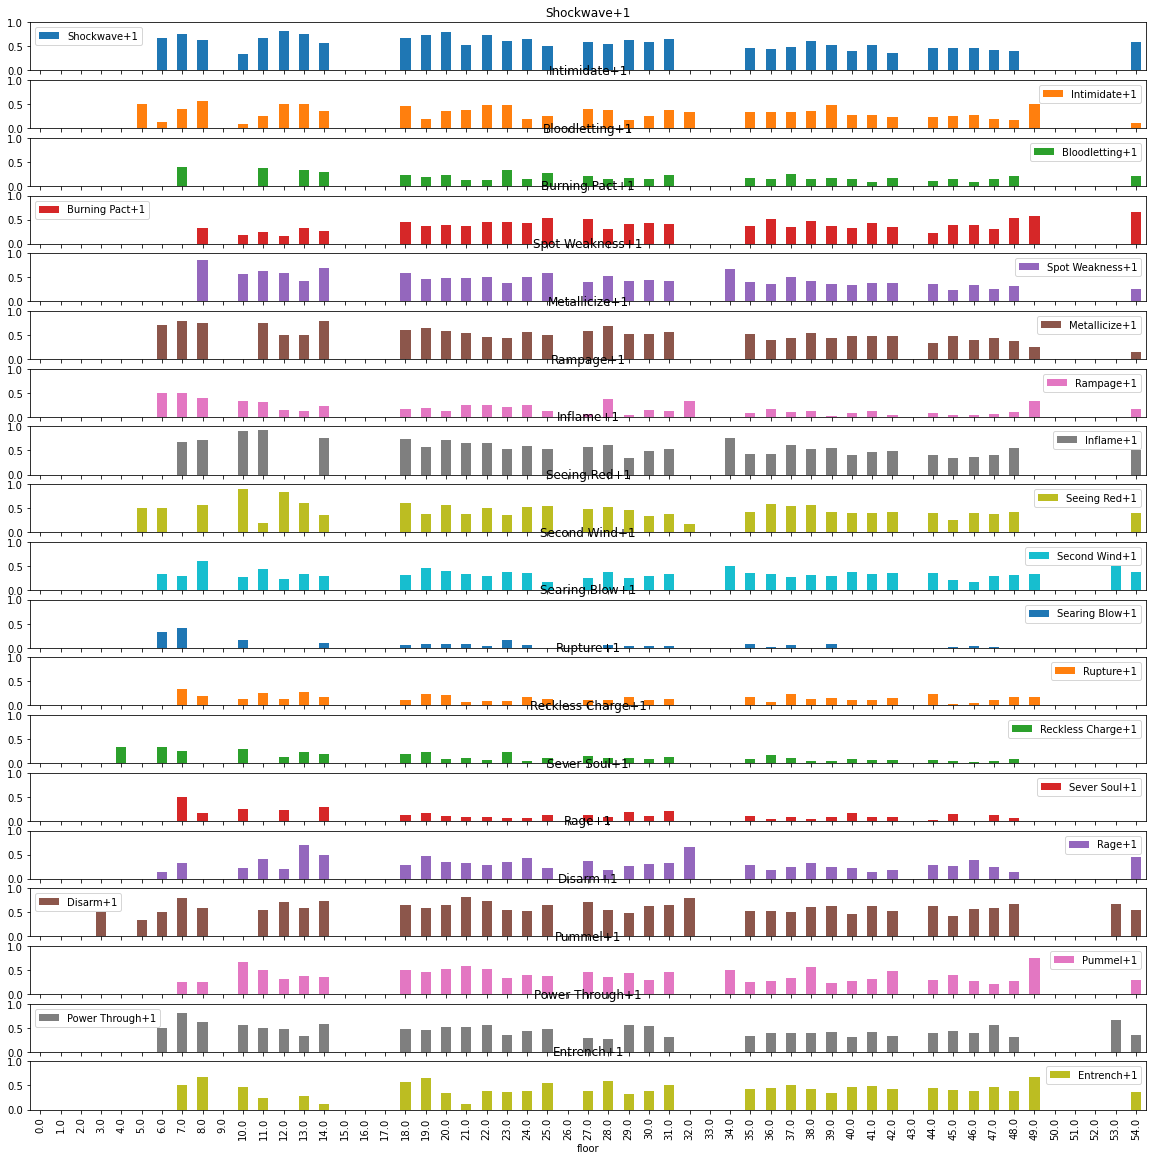

In [17]:
pickrate_df.loc[uncommons_plus].T.plot(kind="bar", figsize=(20, 20), subplots=True, ylim=(0,1))

In [18]:
%%time
picks_df.loc['SKIP']

CPU times: user 353 µs, sys: 15 µs, total: 368 µs
Wall time: 375 µs


floor
0.0        NaN
1.0     1277.0
2.0      540.0
3.0      642.0
4.0      824.0
5.0      960.0
6.0      803.0
7.0     1213.0
8.0     1164.0
9.0        1.0
10.0    1322.0
11.0    1438.0
12.0    1429.0
13.0    1512.0
14.0    2147.0
15.0       2.0
16.0       2.0
17.0       1.0
18.0    3927.0
19.0    1300.0
20.0    1434.0
21.0    1772.0
22.0    2028.0
23.0    1374.0
24.0    2292.0
25.0    1876.0
26.0       4.0
27.0    1970.0
28.0    2172.0
29.0    2219.0
30.0    2192.0
31.0    3011.0
32.0       NaN
33.0       4.0
34.0       1.0
35.0    5110.0
36.0    1757.0
37.0    1951.0
38.0    2274.0
39.0    2542.0
40.0    1799.0
41.0    2440.0
42.0    2078.0
43.0       4.0
44.0    2050.0
45.0    2121.0
46.0    2072.0
47.0    1994.0
48.0    2629.0
49.0       3.0
50.0       3.0
51.0       2.0
52.0       5.0
53.0       4.0
54.0     319.0
Name: SKIP, dtype: float64

In [19]:
picks_df.sum()

floor
0.0      1085.0
1.0     10044.0
2.0      3660.0
3.0      4028.0
4.0      4453.0
5.0      4835.0
6.0      4641.0
7.0      5766.0
8.0      5296.0
9.0         5.0
10.0     5594.0
11.0     5617.0
12.0     5664.0
13.0     5537.0
14.0     7555.0
15.0      120.0
16.0     9368.0
17.0      110.0
18.0    10284.0
19.0     3552.0
20.0     3854.0
21.0     4557.0
22.0     5017.0
23.0     3881.0
24.0     5832.0
25.0     4876.0
26.0        9.0
27.0     5133.0
28.0     5406.0
29.0     5401.0
30.0     5353.0
31.0     7286.0
32.0      291.0
33.0     8538.0
34.0      197.0
35.0    10567.0
36.0     4817.0
37.0     5006.0
38.0     5496.0
39.0     5858.0
40.0     4116.0
41.0     5353.0
42.0     4804.0
43.0       10.0
44.0     4647.0
45.0     4718.0
46.0     4659.0
47.0     4451.0
48.0     5857.0
49.0      261.0
50.0       13.0
51.0        6.0
52.0       32.0
53.0      111.0
54.0      801.0
dtype: float64

array([<AxesSubplot:title={'center':'None'}, xlabel='floor'>],
      dtype=object)

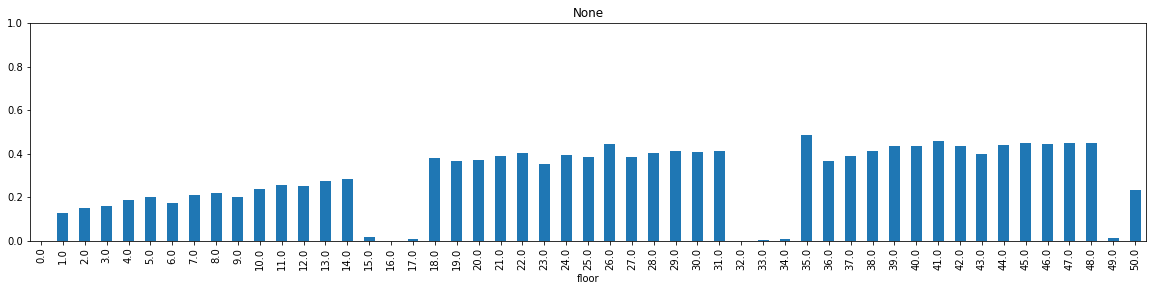

In [20]:
skip_pick_rate = (picks_df.loc['SKIP'] / picks_df.sum())[:50]
skip_pick_rate.plot(kind="bar", figsize=(20, 4), subplots=True, ylim=(0, 1))

CPU times: user 2.43 s, sys: 145 ms, total: 2.58 s
Wall time: 2.43 s


array([<AxesSubplot:title={'center':'Wild Strike'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Perfected Strike'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Anger'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Iron Wave'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Heavy Blade'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Clothesline'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Flex'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Havoc'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Pommel Strike'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Warcry'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Twin Strike'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'True Grit'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Thunderclap'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Sword Boomerang'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Body Slam'}, x

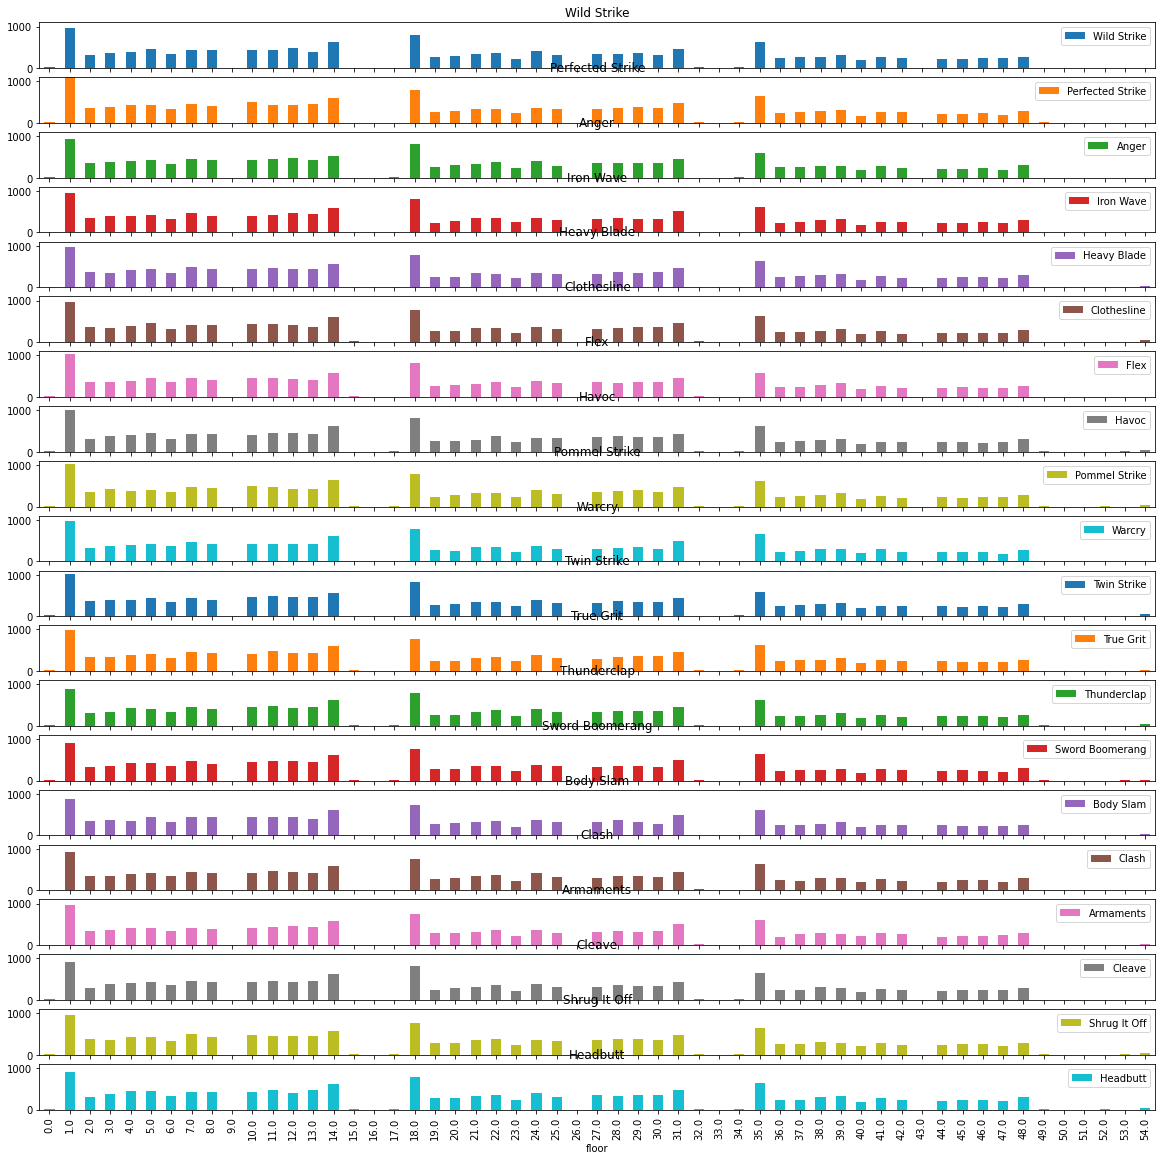

In [21]:
%%time
offered_commons = offered_df.loc[[
    'Wild Strike',
    'Perfected Strike',
    'Anger',
    'Iron Wave',
    'Heavy Blade',
    'Clothesline',
    'Flex',
    'Havoc',
    'Pommel Strike',
    'Warcry',
    'Twin Strike',
    'True Grit',
    'Thunderclap',
    'Sword Boomerang',
    'Body Slam',
    'Clash',
    'Armaments',
    'Cleave',
    'Shrug It Off',
    'Headbutt',
]]
offered_commons.T.plot(kind="bar", figsize=(20, len(offered_commons.index)), subplots=True, ylim=(0, offered_commons.max().max()))

array([<AxesSubplot:title={'center':'Wild Strike+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Perfected Strike+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Anger+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Iron Wave+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Heavy Blade+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Clothesline+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Flex+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Havoc+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Pommel Strike+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Warcry+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Twin Strike+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'True Grit+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Thunderclap+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Sword Boomerang+1'}, xlabel='floor'>,
       <AxesSubplot:tit

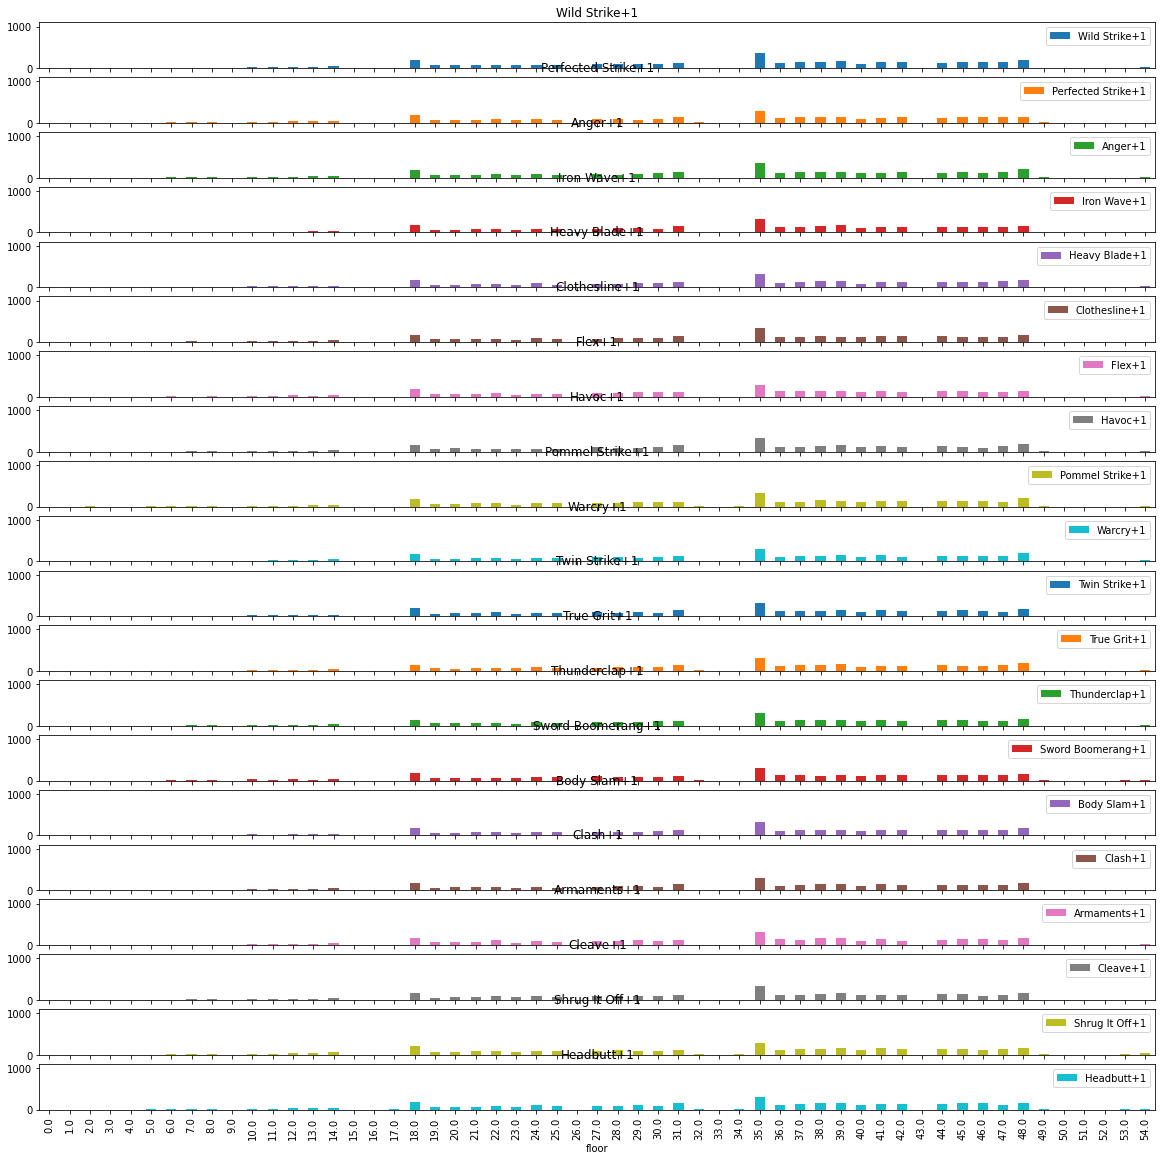

In [22]:
offered_df.loc[commons_plus].T.plot(kind="bar", figsize=(20, len(offered_commons.index)), subplots=True, ylim=(0, offered_commons.max().max()))

array([<AxesSubplot:title={'center':'Shockwave+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Intimidate+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Bloodletting+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Burning Pact+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Spot Weakness+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Metallicize+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Rampage+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Inflame+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Seeing Red+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Second Wind+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Searing Blow+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Rupture+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Reckless Charge+1'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Sever Soul+1'}, xlabel='floor'>,
       <AxesSu

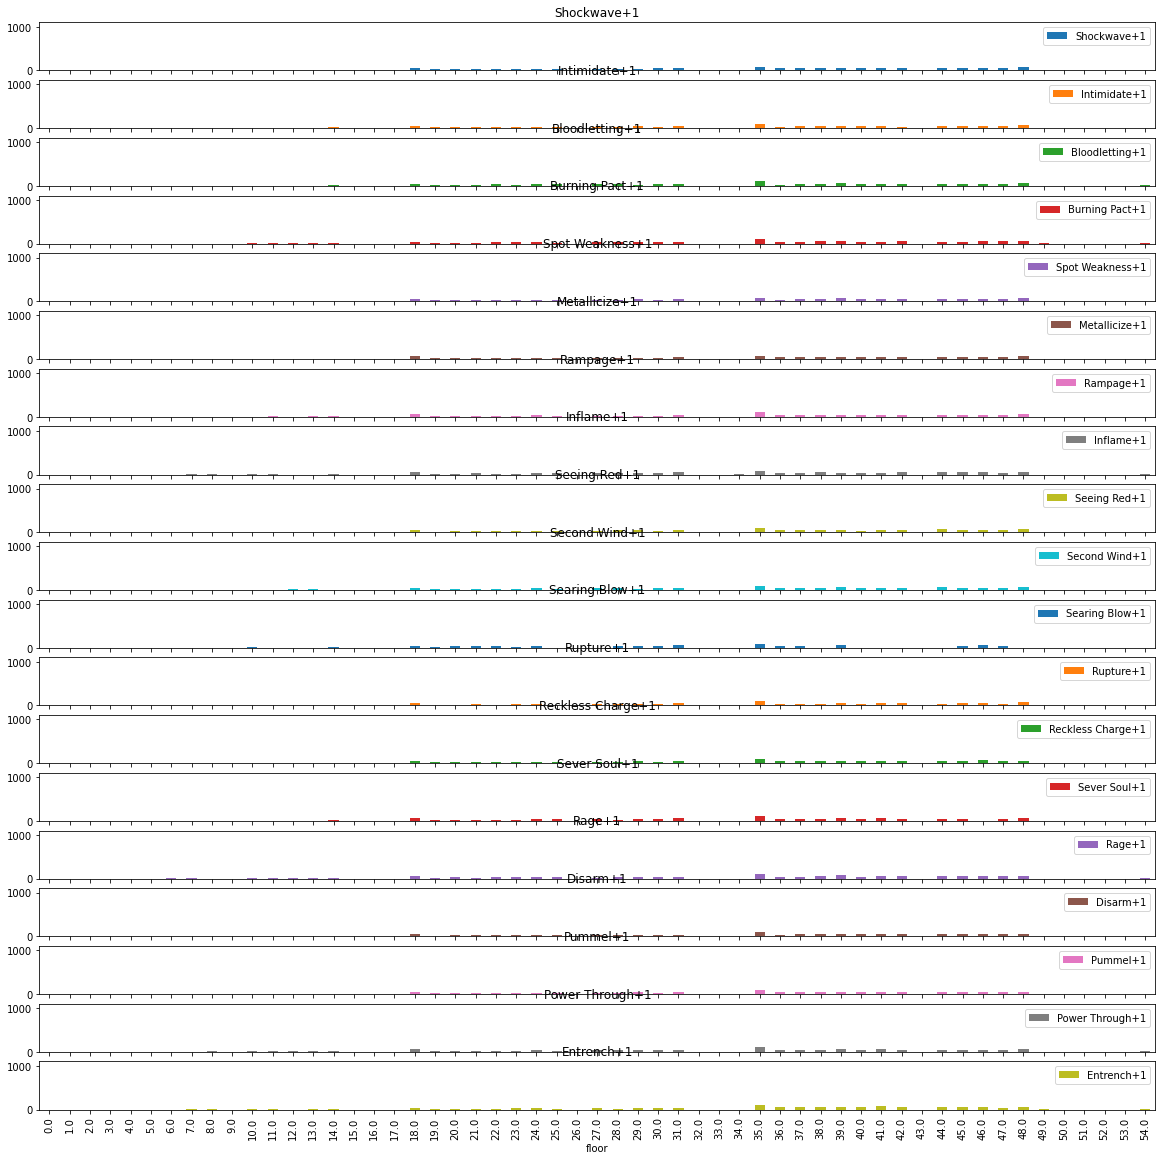

In [23]:
offered_df.loc[uncommons_plus].T.plot(kind="bar", figsize=(20, len(offered_commons.index)), subplots=True, ylim=(0, offered_commons.max().max()))

CPU times: user 1.89 s, sys: 137 ms, total: 2.03 s
Wall time: 1.88 s


array([<AxesSubplot:title={'center':'Shockwave'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Intimidate'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Bloodletting'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Burning Pact'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Spot Weakness'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Metallicize'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Rampage'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Inflame'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Seeing Red'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Second Wind'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Searing Blow'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Rupture'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Reckless Charge'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Sever Soul'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Rage'

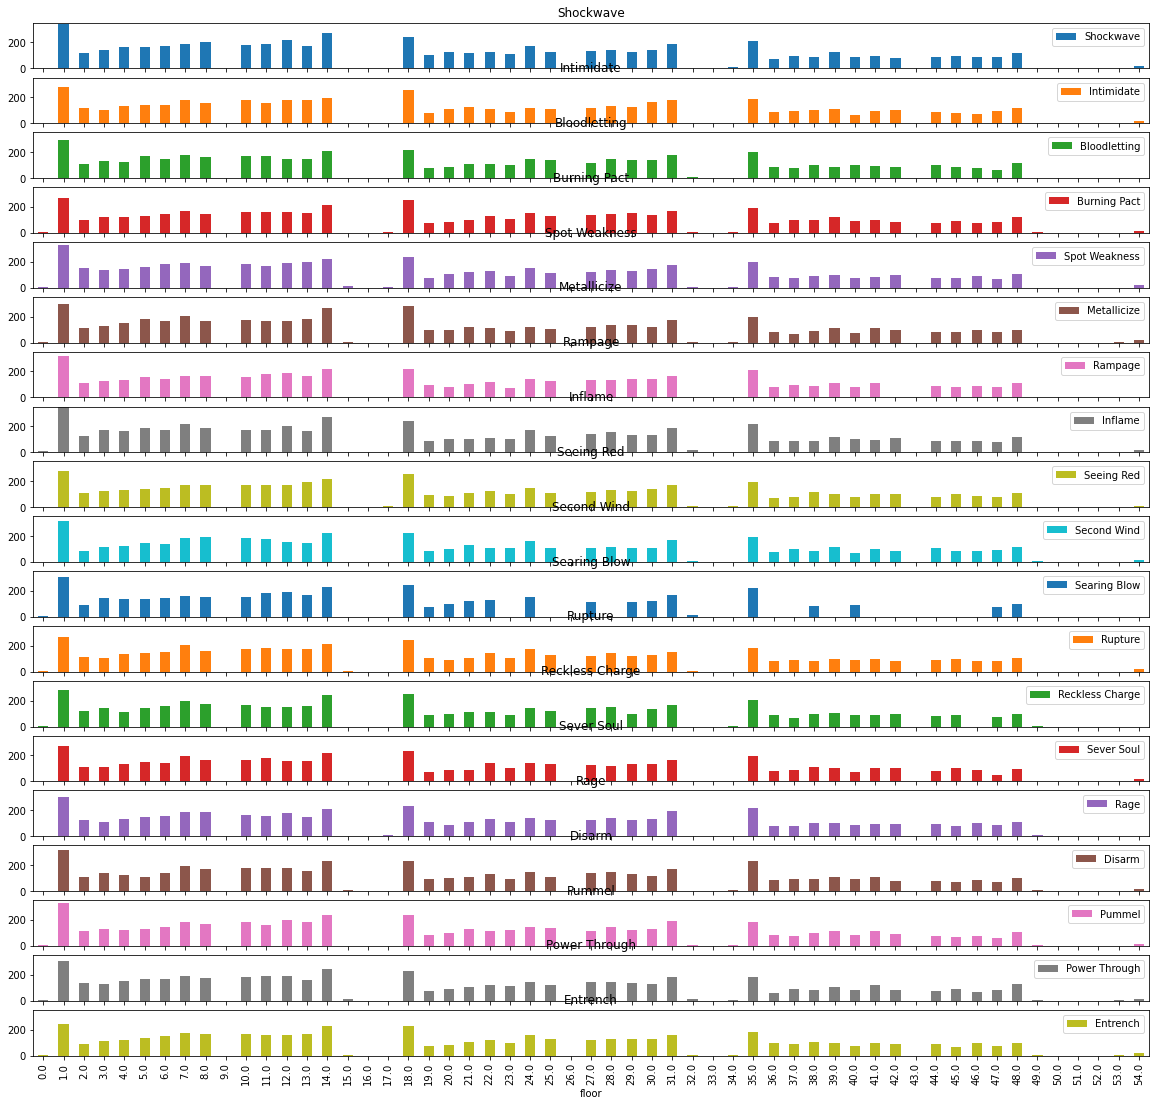

In [24]:
%%time
offered_uncommons = offered_df.loc[[
    'Shockwave',
    'Intimidate',
    'Bloodletting',
    'Burning Pact',
    'Spot Weakness',
    'Metallicize',
    'Rampage',
    'Inflame',
    'Seeing Red',
    'Second Wind',
    'Searing Blow',
    'Rupture',
    'Reckless Charge',
    'Sever Soul',
    'Rage',
    'Disarm',
    'Pummel',
    'Power Through',
    # missing items
    'Entrench',
    # missing items
]]
offered_uncommons.T.plot(kind="bar", figsize=(20, len(offered_uncommons.index)), subplots=True, ylim=(0, offered_uncommons.max().max()))

CPU times: user 1.6 s, sys: 148 ms, total: 1.74 s
Wall time: 1.61 s


array([<AxesSubplot:title={'center':'Demon Form'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Juggernaut'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Offering'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Feed'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Corruption'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Berserk'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Reaper'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Bludgeon'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Limit Break'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Double Tap'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Exhume'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Immolate'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Fiend Fire'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Barricade'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Brutality'}, xlabel='floor'>,
    

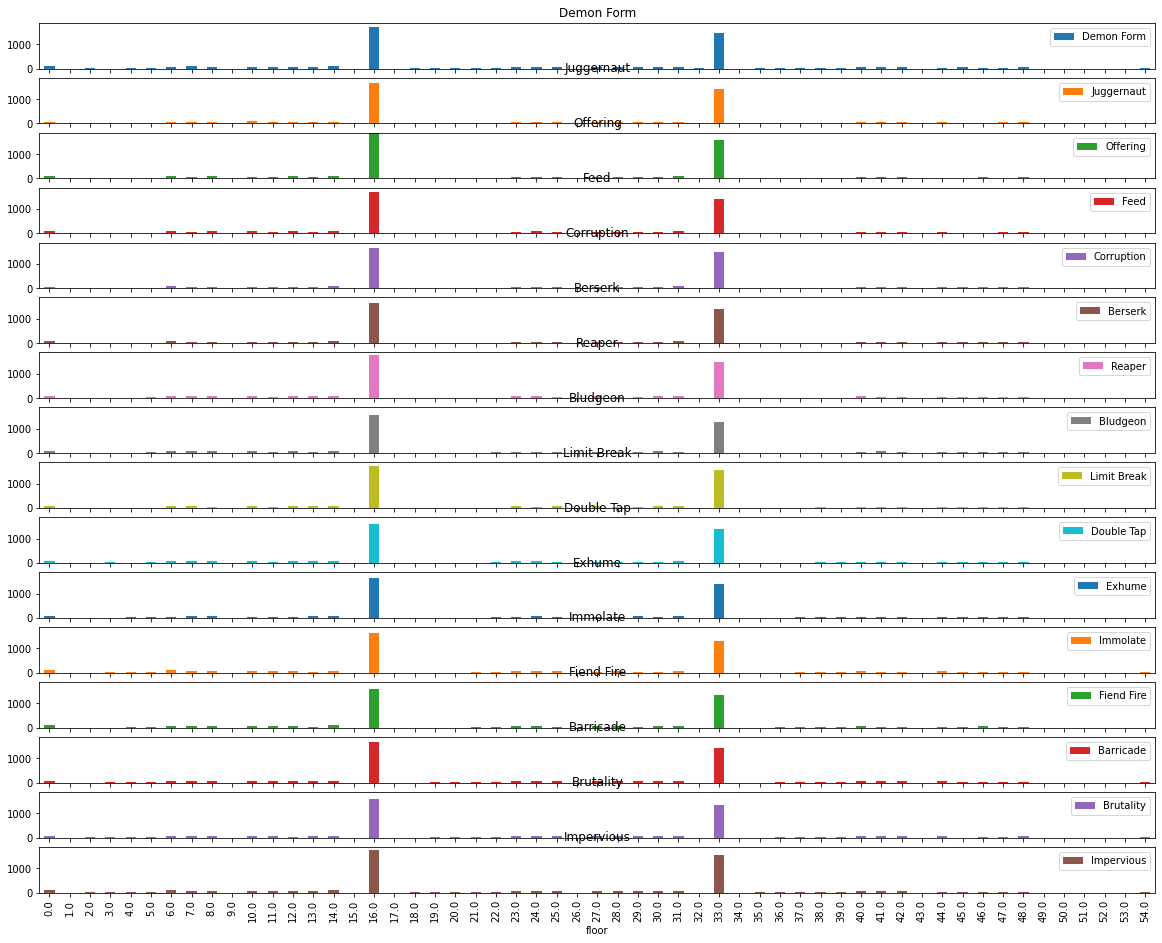

In [25]:
%%time
offered_rares = offered_df.loc[rares]

offered_rares.T.plot(kind="bar", figsize=(20, len(offered_rares.index)), subplots=True, ylim=(0, offered_rares.max().max()))

In [26]:
offers_by_floor = offered_df.sum()
offers_by_floor[:5]

floor
0.0     3187.0
1.0    30061.0
2.0    10929.0
3.0    12020.0
4.0    13314.0
5.0    14447.0
dtype: float64

array([<AxesSubplot:title={'center':'Demon Form'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Juggernaut'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Offering'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Feed'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Corruption'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Berserk'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Reaper'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Bludgeon'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Limit Break'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Double Tap'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Exhume'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Immolate'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Fiend Fire'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Barricade'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Brutality'}, xlabel='floor'>,
    

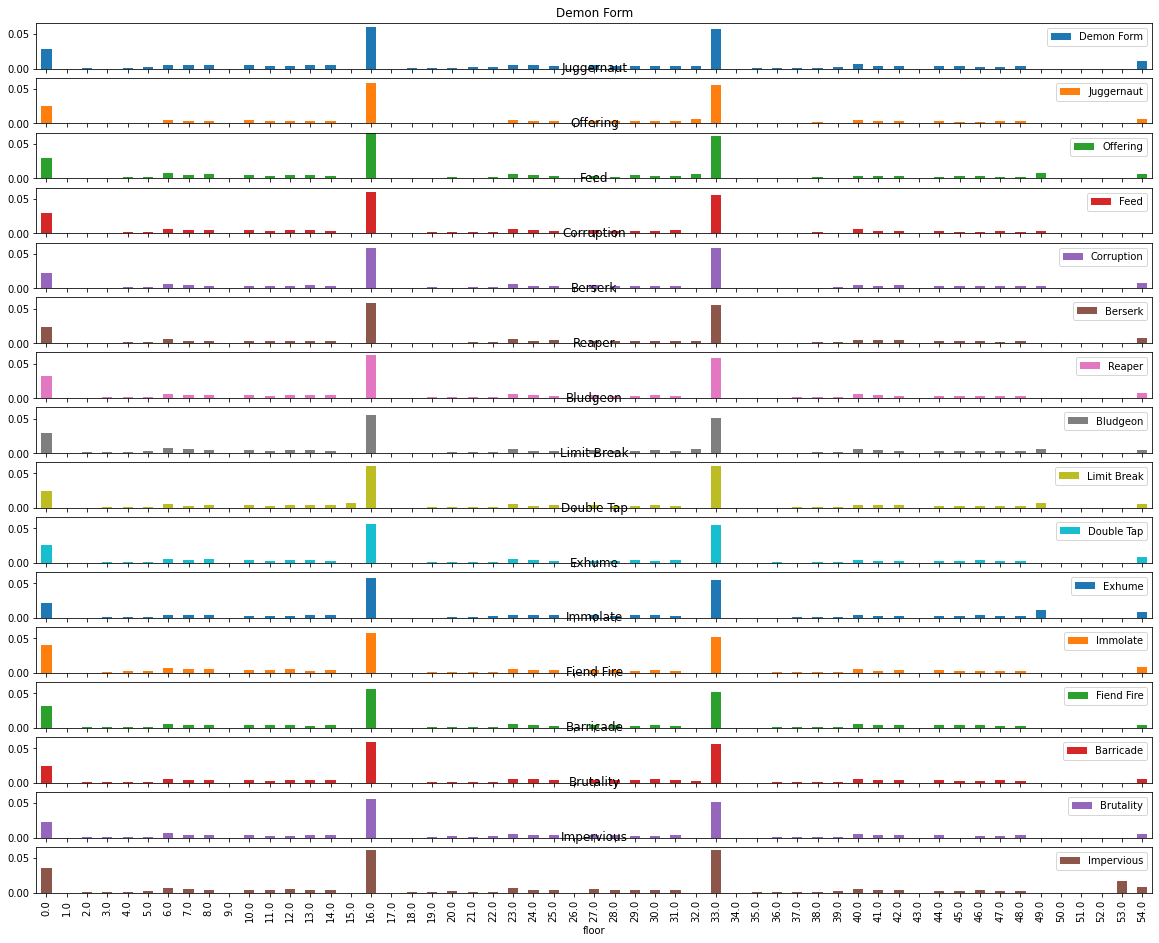

In [27]:
offer_rates = offered_df / offers_by_floor
offer_rates_rares = offer_rates.loc[rares]
offer_rates_rares.T.plot(kind="bar", figsize=(20, len(offer_rates_rares.index)), subplots=True, ylim=(0, offer_rates_rares.max().max()))

In [28]:
a = offered_df.loc['Corruption'][16]
b = offers_by_floor.loc[16]
print(a)
print(b)
print(a / b)
print(offered_df.loc[rares][16].sum())

1648.0
28414.0
0.05799957767297811
26817.0


In [29]:
pickrate_df

floor,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0
card,,,,,,,,,,,,,,,,,,,,,
Anger,0.307692,0.248918,0.232295,0.232432,0.176179,0.191142,0.190476,0.174672,0.163551,NaN,...,0.004902,0.012658,0.016575,0.017007,NaN,NaN,NaN,NaN,NaN,NaN
Anger+1,NaN,NaN,NaN,NaN,0.333333,NaN,0.500000,0.583333,0.250000,NaN,...,0.075758,0.040650,0.044118,0.040404,0.214286,NaN,NaN,NaN,NaN,0.052632
Apotheosis,0.911765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.888889,0.636364,0.750000,0.666667,NaN,NaN,NaN,NaN,NaN,NaN
Apotheosis+1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Armaments,0.333333,0.352098,0.369942,0.337017,0.342995,0.308824,0.260870,0.225653,0.308861,NaN,...,0.022727,0.035088,0.037815,0.034483,NaN,NaN,NaN,NaN,0.166667,0.027027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Warcry+1,NaN,NaN,NaN,0.333333,0.666667,0.666667,0.200000,0.666667,0.117647,NaN,...,0.261905,0.238462,0.225806,0.208333,0.555556,NaN,NaN,NaN,0.500000,0.400000
Whirlwind,0.888889,0.729805,0.661972,0.611511,0.631902,0.581395,0.585227,0.535885,0.463415,NaN,...,0.138889,0.146667,0.085366,0.080000,0.500000,NaN,NaN,NaN,NaN,NaN
Whirlwind+1,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.600000,NaN,NaN,...,0.203125,0.171429,0.264706,0.185714,0.500000,NaN,NaN,NaN,NaN,0.076923


In [31]:
pickrate_df.T.to_json('pickrates_transposed.json')